jupyter nbconvert Documents\mlart\datafest\projects\deepdreamloops.ipynb --to slides --post serve

# 🤖📚🎨 Inside (Looping Deep Dreams)

# What is Deep Dream?

<video src="img/deepdreamwebgl.mp4"></video>

### различные параметризации картинок
https://distill.pub/2018/differentiable-parameterizations/

<video src="img/cppn.mp4"></video>


### Самая свежая статья по теме 

https://distill.pub/2020/circuits/zoom-in/


# Inside: концепция
![alt text](https://i.redd.it/b7ve5g37j0m41.jpg)



In [27]:
from IPython.display import HTML
HTML('<iframe width="800" height="600" src="https://www.youtube.com/embed/hjpFZoppcgM?start=126;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

# Inside: код

Based on https://github.com/ml4a/ml4a-guides/blob/master/notebooks/neural-synth.ipynb by Gene Kogan

a collection of feature vizualizations for googlenet can be found at https://distill.pub/2017/feature-visualization/appendix/





In [0]:
  #Grab inception model from online and unzip it (you can skip this step if you've already downloaded the model.
!wget -P . https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
!unzip inception5h.zip -d inception5h/
!rm inception5h.zip

--2020-01-27 11:37:38--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘./inception5h.zip’

inception5h.zip     100%[===================>]  47.62M   153MB/s    in 0.3s    

2020-01-27 11:37:44 (153 MB/s) - ‘./inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: inception5h/imagenet_comp_graph_label_strings.txt  
  inflating: inception5h/tensorflow_inception_graph.pb  
  inflating: inception5h/LICENSE     


In [0]:
# get some functions from ml4a repository
!wget https://raw.githubusercontent.com/ml4a/ml4a-guides/master/notebooks/lapnorm.py

--2020-01-27 11:37:50--  https://raw.githubusercontent.com/ml4a/ml4a-guides/master/notebooks/lapnorm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4608 (4.5K) [text/plain]
Saving to: ‘lapnorm.py’

lapnorm.py          100%[===================>]   4.50K  --.-KB/s    in 0s      

2020-01-27 11:37:50 (128 MB/s) - ‘lapnorm.py’ saved [4608/4608]



In [0]:
# install deprecated version of scipy
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 94kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [0]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf

import imageio

# import everything from lapnorm.py
from lapnorm import *


Instructions for updating:
Use tf.gfile.GFile.


Number of layers 59
Total number of feature channels: 7548



In [0]:
def save_image(name, im, fmt='jpeg'):
    im = np.uint8(np.clip(im/255., 0, 1)*255)
    with open('{}.jpg'.format(name), 'w') as f:
      PIL.Image.fromarray(im).save(f, fmt)

def dream(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=True, opt_resize=False):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            if opt_resize:
              img = resize(img[crop_px:-crop_px,crop_px:-crop_px,:], (h, w)) 
              display_image(img)

            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    if clear:
        clear_output()
    return img

In [0]:
!wget https://i.imgur.com/U53RWGZ.jpg --output-document /content/blurred_circle.jpg

--2020-01-27 11:38:07--  https://i.imgur.com/U53RWGZ.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.36.193
Connecting to i.imgur.com (i.imgur.com)|151.101.36.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12246 (12K) [image/jpeg]
Saving to: ‘/content/blurred_circle.jpg’

/content/blurred_ci 100%[===================>]  11.96K  --.-KB/s    in 0s      

2020-01-27 11:38:08 (133 MB/s) - ‘/content/blurred_circle.jpg’ saved [12246/12246]



## params



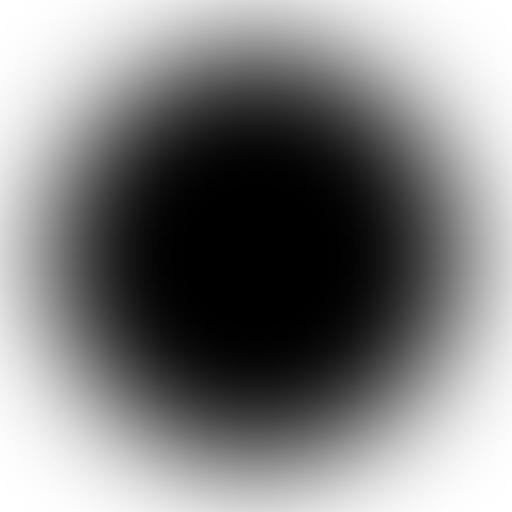

In [0]:
# SET 

h, w = 512, 512  # image size
img0 = np.random.uniform(size=(h, w, 3)) + 100.0

LEN = 90  # animation lenght in frames
crop_px = 5  # from each side of the frame

# upload black and white image to be used as mask
mask_template = load_image('/content/blurred_circle.jpg', h, w)

obj1 = ('mixed5b', 26)  # white objective
obj2 = ('mixed3a', 5)  # black objective

mask_template = mask_template[:,:,0]  # Will use only one channel for binary mask

# VIZUALIZE
display_image(mask_template)

h, w = mask_template.shape

mask = np.ones((h, w, 2))
mask[:, :, 0] = mask_template / 255
mask[:, :, 1] = 1.0 - (mask_template / 255)

octave_n = 2
octave_scale = 1.4
objectives = [T(obj1[0])[:,:,:,obj1[1]], 
              T(obj2[0])[:,:,:,obj2[1]]]


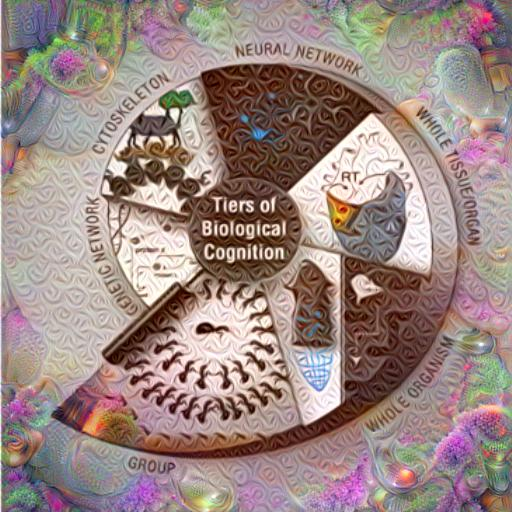

In [0]:
img = dream(objectives, img0, mask, iter_n=42, step=1.0, oct_n=octave_n, oct_s=1.4, lap_n=4)
display_image(img) 

In [0]:
# repeat the generation loop 20 times. notice the feedback -- we make img and then use it the initial input 
for f in range(LEN):
    print("iteration {}".format(f))
    img = dream(objectives, img, mask, iter_n=20, step=1.0, oct_n=octave_n, oct_s=octave_scale, lap_n=4)
    # display_image(img)    # let's see it
    save_image('frame%05d'%f, img)  # ffmpeg to save the frames
    img = resize(img[crop_px:-crop_px,crop_px:-crop_px,:], (h, w))  # before looping back, crop the border by 10 pixels, resize, repeat

print('done')

done


<video src="img/video_3bpool_experiment93.mp4"></video>

In [0]:
# making things loop

# start the last frame, change it if your session crashed
LAST_FRAME = LEN - 1

if LAST_FRAME == LEN - 1:
  START_FRAME = 0
else:
  START_FRAME = LAST_FRAME + 1

img = imageio.imread('frame{:05d}.jpg'.format(LAST_FRAME))

# space = np.cos(np.linspace(0, np.pi, LEN-1)) / 2 + 0.5
space = np.linspace(1, 0, LEN - 1)


for f in range(START_FRAME, LEN - 1):
    print("iteration {}. using {} of prev and {} of next img".format(f, space[f], 1 - space[f]))
    try:
      img_combined = img * space[f] + imageio.imread('frame{:05d}.jpg'.format(f+1)) * (1-space[f])
      # display_image(img_combined)
    except Exception as e:
      print(e)
      
    img = dream(objectives, img_combined, mask, iter_n=20, step=1.0, oct_n=octave_n, oct_s=octave_scale, lap_n=4)
    # display_image(img)    # let's see it
    save_image('looped_frame%05d'%f, img)
    
    img = resize(img[crop_px:-crop_px,crop_px:-crop_px,:], (h, w)) 



In [ ]:
!mv looped_frame00088.jpg unused_frame.jpg
!ffmpeg -f image2 -r 30 -vb 20M -pattern_type glob -i 'looped_frame*.jpg' video.mp4

<video src="img/4a460.mp4"></video>